In [5]:
!git clone https://github.com/victorsxw/detect-parkinson-xgb.git  # Replace with your repo URL

Cloning into 'detect-parkinson-xgb'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 75 (delta 2), reused 1 (delta 1), pack-reused 67 (from 1)
Receiving objects: 100% (75/75), 723.36 KiB | 1.93 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
!pip install scikit-learn==1.5.2 xgboost==1.7.6

- ### Import necessary packages

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

- ### Read data
We will be using pandas.read_csv function to read data file saved in form of csv(comma seperated values) format

In [4]:
df = pd.read_csv('detect-parkinson-xgb/parkinsons.csv')

- ##### Overview of our dataframe:
We will use DataFrame.head() which helps to get a overview on our dataset i.e by default it will show `top 5 rows` in our dataframe. We can change the default value by passing any number eg. df.head(NUM) where NUM it the total number of row you want to display

In [5]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


- ##### Summary of our dataframe:
To have a good graps on our data we will take a look at column names to refer them further, total non-null count in that column and the data-type of respective columns we will use DataFrame.info() function as show below

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

- ### Statistic on our data
We can have a brief analysis on our dataframe using `DataFrame.describe` function. Let me elaborate the output w.r.t each columns:
    - `count`: total no. of data entries
    - `mean`: mean of all the values (does not work for character/string columns)
    - `std`: [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) i.e dispersion from mean
    - `min`: smallest value
    - `25%`: 25% of all your values are below that value
    - `50%`: 50% of all your values are below that value (this is also the median of the column)
    - `75%`: 75% of all your values are below that value <br>
    (for 100 data entries in a columsn 25%, 50% and 75% will give 25th, 50th and 75th value)
    - `max`: largest value


In [7]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


- ##### Verify if our dataset has any null values
    - DataFrame.isna() returns a DataFrame with boolean values i.e if value is null return False else return True <br>
    - Applying .sum() on the method above will sum the total count of true values for that column <br>
(First execute DataFrame.isna() to check how an boolean dataframe looks like)


In [8]:
df.isna().sum()

,0
name,0
MDVP:Fo(Hz),0
MDVP:Fhi(Hz),0
MDVP:Flo(Hz),0
MDVP:Jitter(%),0
MDVP:Jitter(Abs),0
MDVP:RAP,0
MDVP:PPQ,0
Jitter:DDP,0
MDVP:Shimmer,0


- ### Undestanding correlation using Heatmap visulisation .
- #### What is correlation ?
    - Checking correlations is an important part of the exploratory data analysis proces </br>
    - Correlation is a term that is a measure of the strength of a linear relationship between two quantitative variables (so,  higher the correlation value higher is the dependecy of variables on each other)
    - Positive correlation is a relationship between two variables in which both variables move in the same direction. This is when one variable increases while the other increases and visa versa.
    -  Where as negative correlation is a relationship where one variable increases as the other decreases, and vice versa.
    - Function to create 2d correlation matrix `DataFrame.corr()`
- #### What is a Heatmap ?
    - A heat map is a data visualization technique that shows magnitude of a phenomenon as color in two dimensions. The variation in color represent varuable in values.
    - A simple way to plot a heatmap in Python is by importing and implementing the [Seaborn library](https://seaborn.pydata.org/)
    - Function to drwa a heatmap `Seaborn.heatmap()`
    - Important paramteres of heatmap function
        - `data`: a 2d array
        - `annot`: if True, writes the data value in each cell

<Axes: >

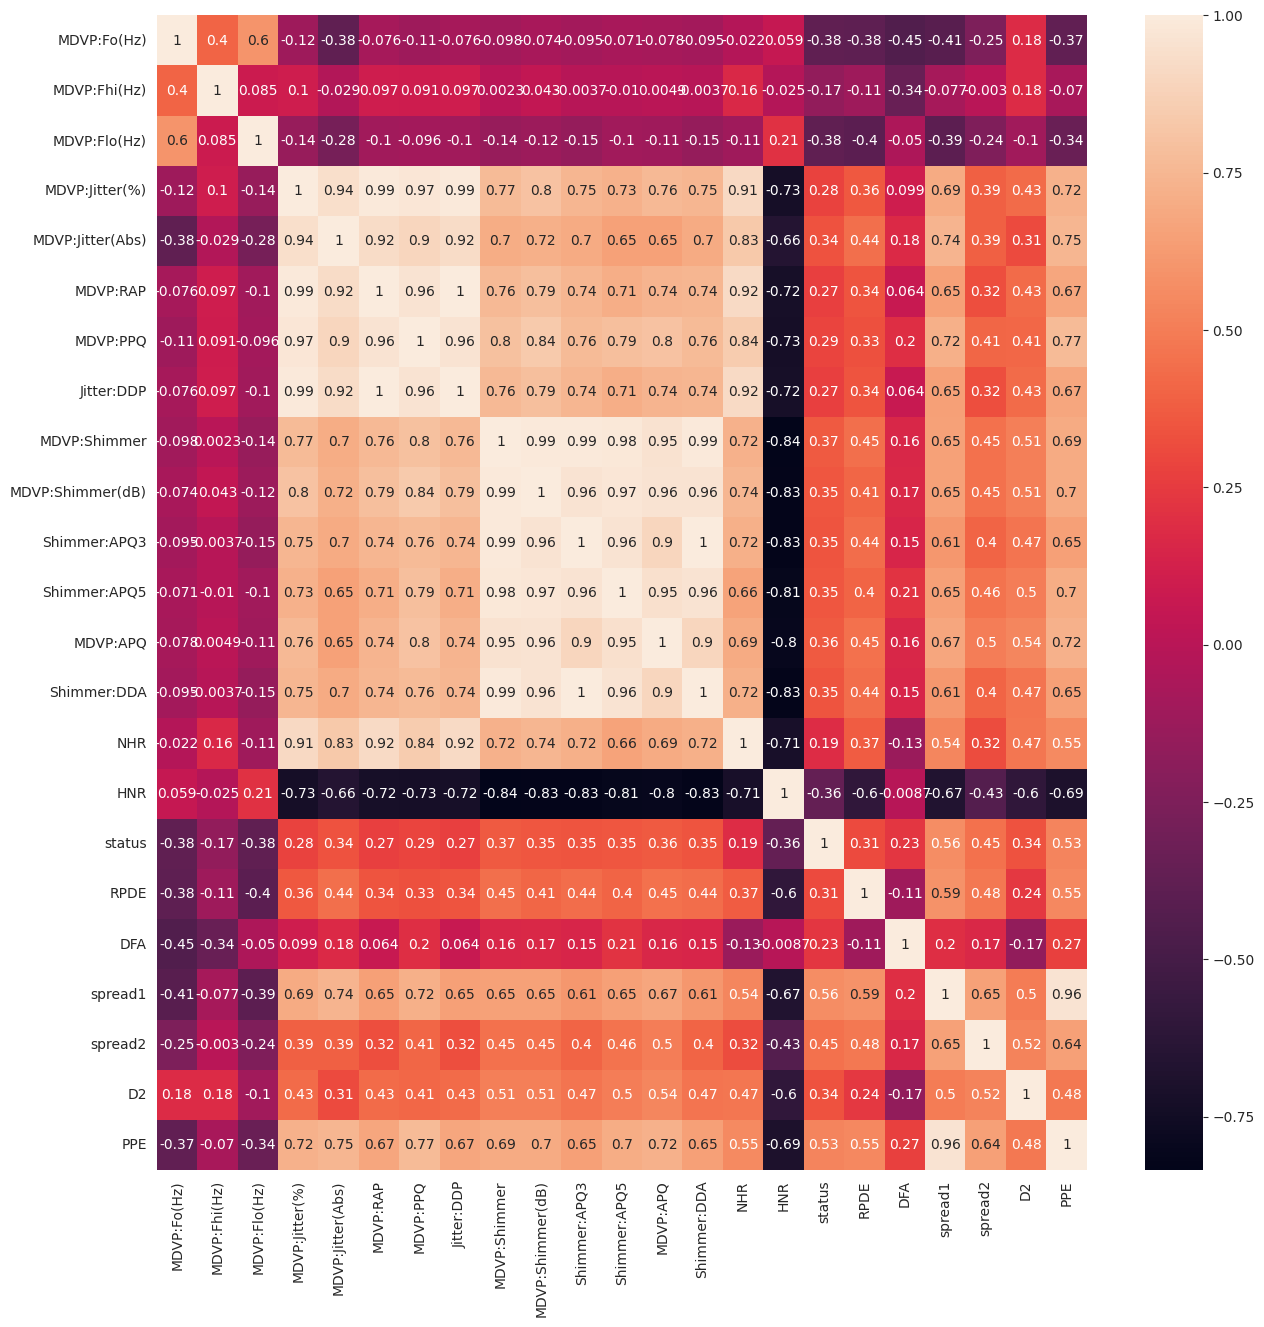

In [9]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix using the numerical columns
corr_map = numerical_df.corr()

sns.set_style('darkgrid')
# sns.set_style help to set color of the axes, whether a grid is enabled by default, and other aesthetic elements.
plt.figure(figsize=(15,15))
sns.heatmap(data=corr_map, annot=True)

In [10]:
numerical_df = df.select_dtypes(include=['number'])
correlation_values = numerical_df.corr()['status']
correlation_values.abs().sort_values(ascending=False)

,status
status,1.000000
spread1,0.564838
PPE,0.531039
spread2,0.454842
MDVP:Fo(Hz),0.383535
MDVP:Flo(Hz),0.380200
MDVP:Shimmer,0.367430
MDVP:APQ,0.364316
HNR,0.361515
Shimmer:APQ5,0.351148


- ### Correlation of target label `status` with each feature
    - `df.corr()['status']` will return the correlation values status column
    - `correlation_values.abs().sort_values(ascending=False)` this will covert the correlation values to positive and then sort them in descending order <br>
    (This will help us sort correlation values)

- ### Extract features and taget label into two different dataframes
    - `df.loc[:,df.columns!='status']` : extract all columns except label `status`
    - `df.loc[:,'status']` : extract taget column named `status`

In [11]:
features=df.loc[:,df.columns!='status']
labels=df.loc[:,'status']

- ###### Analyse  count of people affected as well as not affected with Parkinson disease
    - `labels[labels==0].shape` : returns total number of rows with target lable 0 (Not having parkinson disease)
    - `labels[labels==1].shape` : returns total number of rows with target label 1 (Having parkinson disease)

In [13]:
print("Examples with label '0': {}\n Examples with label '1': {}".format(labels[labels==0].shape, labels[labels==1].shape))

Examples with label '0': (48,)
 Examples with label '1': (147,)


- #### Preprocessing our data with MinMax Scaler
    - `MinMaxScaler()` transforms features by scaling each feature to a given range.
    - This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between (-1,1).
    - So, we will first initialise our MinMaxSacler

In [14]:
mm_scaler = MinMaxScaler(feature_range=(-1,1))

- #### Fit and Transform using MinMax Scaler
    - what fit_transform does is that performs the necessary calculation first and then do transformation on that data
    - The basic formula for Min-Max scaling is how below: <br>
    ![](https://media.geeksforgeeks.org/wp-content/uploads/min-max-normalisation.jpg)

In [15]:
X = mm_scaler.fit_transform(features.drop('name', axis=1))
y = labels.values

- #### Train Test Split
    - The train_test_split function is for splitting a single dataset for two different purposes: training and testing. The testing subset is for building your model.
    - The testing subset is for using the model on unknown data to evaluate the performance of the model
    - Some important paramaters of train_test_split() are as follows:
        - `X, y`: The first parameter is the dataset you're selecting to use.
        - `test_size`: This parameter specifies the size of the testing dataset.
        - `random_state`: To save the state of train_test_split so that the radnom split generated is same every time.
    - We have distrbuted our data as follows:<br>
        - `train data`: 70% of total data
        - `test_data`: 30% of total data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

- ### We will be using [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/)
- #### As necessary part, I will discuss some important parameters of XGBoost Classifier
    - booster [default=gbtree]
      - Select the type of model to run at each iteration. It has 2 options:
        1. gbtree: tree-based models
        2. gblinear: linear models
    - silent [default=0]:
      - Silent mode is activated is set to 1, i.e. no running messages will be printed.
      - It’s generally good to keep it 0 as the messages might help in understanding the model.

    - eta [default=0.3]
      - Analogous to learning rate in GBM
      - Makes the model more robust by shrinking the weights on each step
      - Typical final values to be used: 0.01-0.2

    - min_child_weight [default=1]
      - Defines the minimum sum of weights of all observations required in a child.
      - This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
      - Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
      - Too high values can lead to under-fitting hence, it should be tuned using CV.
    - max_depth [default=6]
      - The maximum depth of a tree, same as GBM.
      - Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
      - Should be tuned using CV.
      - Typical values: 3-10
    - max_leaf_nodes
      - The maximum number of terminal nodes or leaves in a tree.
      - Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
      - If this is defined, GBM will ignore max_depth.
gamma [default=0]
      - A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
      - Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    - subsample [default=1]
      - Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
      - Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
      - Typical values: 0.5-1
    - lambda [default=1]
      - L2 regularization term on weights (analogous to Ridge regression)
      - This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
    - alpha [default=0]
      - L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
    - scale_pos_weight [default=1]
        - A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
     

#### I have not provided any paramter to the XGBosot Classifier Model ,  I will be using the default values but you can try different values

In [17]:
xbg_model = XGBClassifier()
xbg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

- We will initialize a `XGBClassier model`
- Train and fit our `train data` on the classfier with method : <br>
    `xbg_model.fit(X_train, y_train)`

- ####  Prediction on test data
    - Predict with `test data` using:<br>
        `xbg_model.predict(X_test)`

In [18]:
y_pred = xbg_model.predict(X_test)

- ### Performance of our classification model using `confusion matix`
    - In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix are highly dependable output matrix.
    - A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known
    - Its give summary of prediction results on a classification problem.
    - The number of correct and incorrect predictions are summarized with count values and broken down by each class.
    - This is the key to the confusion matrix.
    - The confusion matrix shows the ways in which your classification model is confused when it makes predictions.
    - It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

|  | Predicted Positive | Predicted Negative  |
| :- | -: | :-: |
| Actual Positive | True Positive | False Negative |
| Actula Negative | False Positive | True Negative |

 - ### Sklearn's [ confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) can be used as follow:
    confusion_matrix(y_true, y_pred)

In [19]:
print(confusion_matrix(y_test, y_pred))

[[14  2]
 [ 1 42]]


- #### From our confusion matrix we can conclude that we have predict about 3 wrong prediction:
    - 2 are False Negative
    - 1 is False Positve
- That mean our model has classified 2 patients as `negative` even when they were `positive` and 1 patient as `positive` even if he was `negative`
- In Medical diagnosis we can deal with `False Positives` but we cannot use the results directly from a model that has higher number of `False Negative` at any cost
- So, what we do is tune(improve) our model and always try reduce False Negative as much as possible which untimately increases the model accuarcy    

- ### Our classification model [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
    - The most common metric for classification is accuracy, which is the fraction of samples predicted correctly
    - Accuracy is the ratio of Total No. Correct prediction and Total No. of Predictions  

In [21]:
print(accuracy_score(y_test, y_pred))

0.9491525423728814


#### Using XGBoost Classifier we have got about 94.91% which approximately 94.5% accuaracy
- We have got pretty good accuary on predicting our data